In [1]:
import time
t1 = time.time()

import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import ripser
import persim

In [2]:
##### setting file path #####

sig_rootpath = "/data/Chen-Wang/gghh_highPT_250_200K/Events/run_01_decayed_1/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

ttbarBG_rootpath = "/data/Chen-Wang/ttbarBG_200K/Events/run_01/tag_1_delphes_events.root"
ttbarBG_file = uproot.open(ttbarBG_rootpath)

jjBG_rootpath = "/data/Chen-Wang/jjBG_200PT_200K/Events/run_01/tag_1_delphes_events.root"
jjBG_file = uproot.open(jjBG_rootpath)

In [3]:
##### include signal data #####

sig_events = [sig_file["Delphes;1"]["FatJet"].array(),
        sig_file["Delphes;1"]["FatJet.Eta"].array(),
        sig_file["Delphes;1"]["FatJet.Phi"].array(),
        sig_file["Delphes;1"]["FatJet.PT"].array(),
        sig_file["Delphes;1"]["FatJet.Mass"].array(),
        sig_file["Delphes;1"]["FatJet.Tau[5]"].array(),
        sig_file["Delphes;1"]["FatJet.Particles"].array(),
        sig_file["Delphes;1"]["Particle.PT"].array(),
        sig_file["Delphes;1"]["Particle.Eta"].array(),
        sig_file["Delphes;1"]["Particle.Phi"].array()
        ]

##### reshape the signal data #####

sig_events = np.expand_dims(sig_events, axis=-1)
sig_events = sig_events.transpose((1,0,2))
sig_events = np.squeeze(sig_events,axis=(2,))

num_sig = len(sig_events)

##### include ttbarBG data #####

ttbarBG_events = [ttbarBG_file["Delphes;1"]["FatJet"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Eta"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Phi"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.PT"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Mass"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Tau[5]"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Particles"].array(),
        ttbarBG_file["Delphes;1"]["Particle.PT"].array(),
        ttbarBG_file["Delphes;1"]["Particle.Eta"].array(),
        ttbarBG_file["Delphes;1"]["Particle.Phi"].array()
        ]

##### reshape the ttbarBG data #####

ttbarBG_events = np.expand_dims(ttbarBG_events, axis=-1)
ttbarBG_events = ttbarBG_events.transpose((1,0,2))
ttbarBG_events = np.squeeze(ttbarBG_events,axis=(2,))

num_ttbarBG = len(ttbarBG_events)

##### include jjBG data #####

jjBG_events = [jjBG_file["Delphes;1"]["FatJet"].array(),
        jjBG_file["Delphes;1"]["FatJet.Eta"].array(),
        jjBG_file["Delphes;1"]["FatJet.Phi"].array(),
        jjBG_file["Delphes;1"]["FatJet.PT"].array(),
        jjBG_file["Delphes;1"]["FatJet.Mass"].array(),
        jjBG_file["Delphes;1"]["FatJet.Tau[5]"].array(),
        jjBG_file["Delphes;1"]["FatJet.Particles"].array(),
        jjBG_file["Delphes;1"]["Particle.PT"].array(),
        jjBG_file["Delphes;1"]["Particle.Eta"].array(),
        jjBG_file["Delphes;1"]["Particle.Phi"].array()
        ]

##### reshape the jjBG data #####

jjBG_events = np.expand_dims(jjBG_events, axis=-1)
jjBG_events = jjBG_events.transpose((1,0,2))
jjBG_events = np.squeeze(jjBG_events,axis=(2,))

num_jjBG = len(jjBG_events)

/usr/local/lib/python3.8/dist-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


In [4]:
##### useful function #####

##### select if Fat Jet >= 2 #####

def Fat_Jet_selection(events):
    where1 = np.where(events[:,0]>=2)    ### 0: number of fat jet
    return events[where1]

##### select if M_jet > 50 GeV #####

def mass_selection(events):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][4][0]<50:
            switch=0
        if events[i][4][1]<50:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

# ##### select if Btag (small jet) >= 2 #####

# def Btag_selection(events):
#     where1 = []
#     for i in range(len(events)):
#         if np.sum(events[i][5]) >= 2:    ### 5: Jet.BTag
#             where1.append(i)
#     return events[where1]

##### calculate X_HH #####

def X_HH(jet_mass1, jet_mass2):
    diff1 = jet_mass1 - 124
    diff2 = jet_mass2 - 124
    if diff1<diff2:
        m1 = jet_mass1
        m2 = jet_mass2
    else:
        m1 = jet_mass2
        m2 = jet_mass1
    return np.sqrt(((m1-124)/(0.1*m1+0.00001))**2 + ((m2-115)/(0.1*m2+0.00001))**2)

# ##### select X_HH < 10 #####

# def X_HH_selection(events):
#     where1 = []
#     for i in range(len(events)):
#         if X_HH(events[i][4][0], events[i][4][1]) < 10:
#             where1.append(i)
#     return events[where1]

##### calculate iht #####

def iht(events):
    return events[3][0]+events[3][1]

##### calculate M_JJ #####

def m_JJ(events):
    p = [0,0,0,0]    ### four momentum
    for i in range(2):    ### leading jet and sub-leading jet
        pt = events[3][i]    ### 3: pT of fat jet
        eta = events[1][i]    ### 1: eta of fat jet
        phi = events[2][i]    ### 2: phi of fat jet
        mass = events[4][i]    ### 4: mass of fat jet
        p[1] = p[1] + pt*np.cos(phi)    ### px
        p[2] = p[2] + pt*np.sin(phi)    ### py
        p[3] = p[3] + pt*np.sinh(eta)    ### pz
        p[0] = p[0] + np.sqrt( mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
    m_JJ = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
    return m_JJ

##### calculate deta_JJ #####

def deta_JJ(events):
    eta_J1 = events[1][0]
    eta_J2 = events[1][1]
    return abs(eta_J1-eta_J2)

##### calculate dphi_JJ #####

def dphi_JJ(events):
    phi_J1 = events[2][0]
    phi_J2 = events[2][1]
    return abs(phi_J1-phi_J2)

##### calculate J1_tau21 #####

def J1_tau21(events):
    tau2 = events[5][0][1]
    tau1 = events[5][0][0]
    return tau2/tau1

##### calculate J2_tau21 #####

def J2_tau21(events):
    tau2 = events[5][1][1]
    tau1 = events[5][1][0]
    return tau2/tau1

##### calculate TDA #####

def TDA(event):
    where_jet_particle = event[6][0]+event[6][1]    ### 6: fat jet particles
    where_jet_particle = np.array(where_jet_particle)-1
    center_eta = (event[1][0]+event[1][1])/2    ### 1: fat jet eta
    center_phi = (event[2][0]+event[2][1])/2    ### 2: fat jet phi
    particle_eta = event[8][where_jet_particle]-center_eta    ### 8: particle eta, and centerize
    particle_phi = event[9][where_jet_particle]-center_phi    ### 9: particle phi, and centerize

    where_larger_pi = np.where(particle_phi>np.pi)
    particle_phi[where_larger_pi] = -(2*np.pi - particle_phi[where_larger_pi])    ### check if jet particle split
    where_smaller_mpi = np.where(particle_phi<-np.pi)
    particle_phi[where_smaller_mpi] = 2*np.pi + particle_phi[where_smaller_mpi]    ### check if jet particle split
    P = np.array([particle_eta, particle_phi]).T
    diagrams = ripser.ripser(P)['dgms']
    return diagrams

##### calculate TDA sum of lifetime #####

def TDA_sum(diagrams):
    sum_l0 = np.sum(diagrams[0][:-1,1] - diagrams[0][:-1,0])
    sum_l1 = np.sum(diagrams[1][:,1] - diagrams[1][:,0])
    return sum_l0, sum_l1

##### calculate TDA mean of lifetime #####

def TDA_mean(diagrams):
    l0 = diagrams[0][:-1,1]-diagrams[0][:-1,0]
    l1 = diagrams[1][:,1]-diagrams[1][:,0]
    if np.sum(l1)==0:
        l1 = np.concatenate([l1,[0]])
    return np.mean(l0), np.mean(l1)

##### calculate TDA entropy #####

def TDA_entropy(diagrams):
    l0 = diagrams[0][:-1,1]-diagrams[0][:-1,0]
    L0 = np.sum(l0)
    S0 = (l0/L0)*np.log2((l0/L0))
    l1 = diagrams[1][:,1]-diagrams[1][:,0]
    L1 = np.sum(l1)
    S1 = (l1/L1)*np.log2((l1/L1))
    return -np.sum(S0), -np.sum(S1)

##### calculate TDA Lifetime*Birthtime #####

def TDA_LB(diagrams):
    return np.sum(diagrams[1][:,0]*(diagrams[1][:,1]-diagrams[1][:,0]))

In [5]:
##### basic selection #####

sig_events = Fat_Jet_selection(sig_events)
sig_events = mass_selection(sig_events)
print("There are", len(sig_events), "signal events left after the selection with originally event number", num_sig)

ttbarBG_events = Fat_Jet_selection(ttbarBG_events)
ttbarBG_events = mass_selection(ttbarBG_events)
print("There are", len(ttbarBG_events), "ttbarBG events left after the selection with originally event number", num_ttbarBG)

jjBG_events = Fat_Jet_selection(jjBG_events)
jjBG_events = mass_selection(jjBG_events)
print("There are", len(jjBG_events), "jjBG events left after the selection with originally event number", num_jjBG)

There are 140271 signal events left after the selection with originally event number 200000
There are 109522 ttbarBG events left after the selection with originally event number 200000
There are 54308 jjBG events left after the selection with originally event number 200000


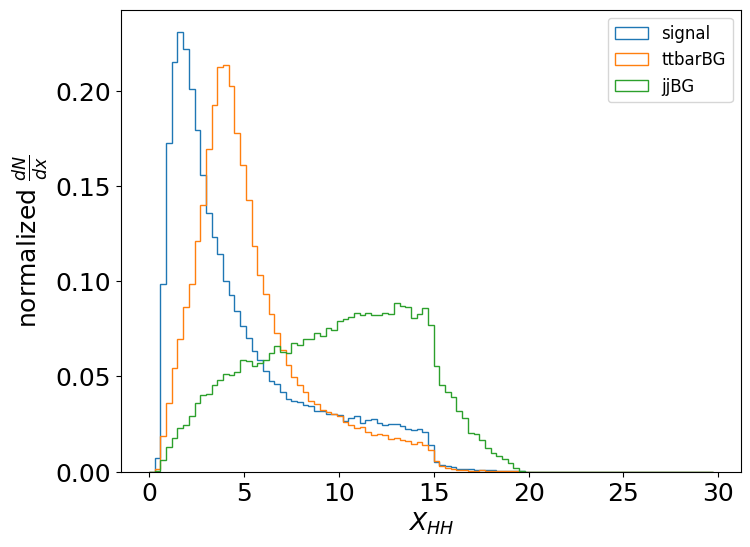

In [6]:
##### plot X_HH distribution #####

sig_X_HH = []
ttbarBG_X_HH = []
jjBG_X_HH = []

for i in range(len(sig_events)):
    sig_X_HH.append(X_HH(sig_events[i][4][0], sig_events[i][4][1]))

for i in range(len(ttbarBG_events)):
    ttbarBG_X_HH.append(X_HH(ttbarBG_events[i][4][0], ttbarBG_events[i][4][1]))

for i in range(len(jjBG_events)):
    jjBG_X_HH.append(X_HH(jjBG_events[i][4][0], jjBG_events[i][4][1]))

plt.figure(1, figsize=(8,6))
bins = np.arange(0,30,0.3)
plt.hist(sig_X_HH, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_X_HH, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_X_HH, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$X_{HH}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

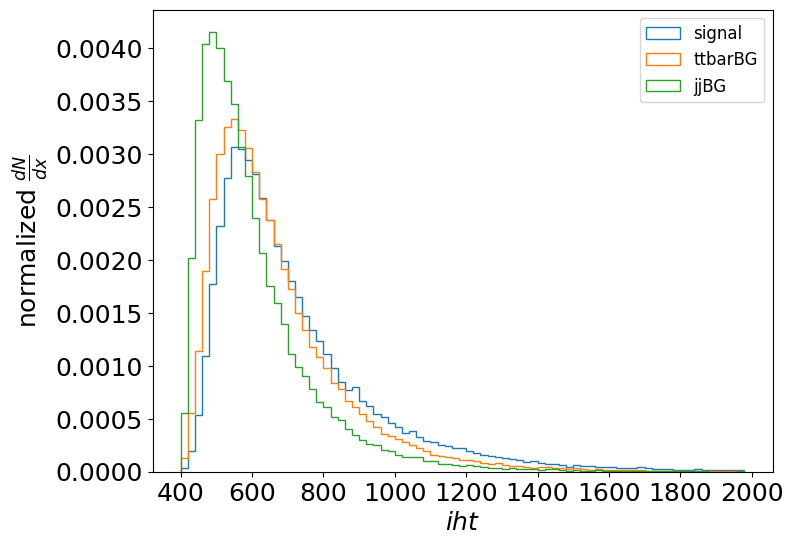

In [7]:
##### plot iht distribution #####

sig_iht = []
ttbarBG_iht = []
jjBG_iht = []

for i in range(len(sig_events)):
    sig_iht.append(iht(sig_events[i]))
    
for i in range(len(ttbarBG_events)):
    ttbarBG_iht.append(iht(ttbarBG_events[i]))
    
for i in range(len(jjBG_events)):
    jjBG_iht.append(iht(jjBG_events[i]))
    
plt.figure(1, figsize=(8,6))
bins = np.arange(400,2000,20)
plt.hist(sig_iht, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_iht, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_iht, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$iht$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

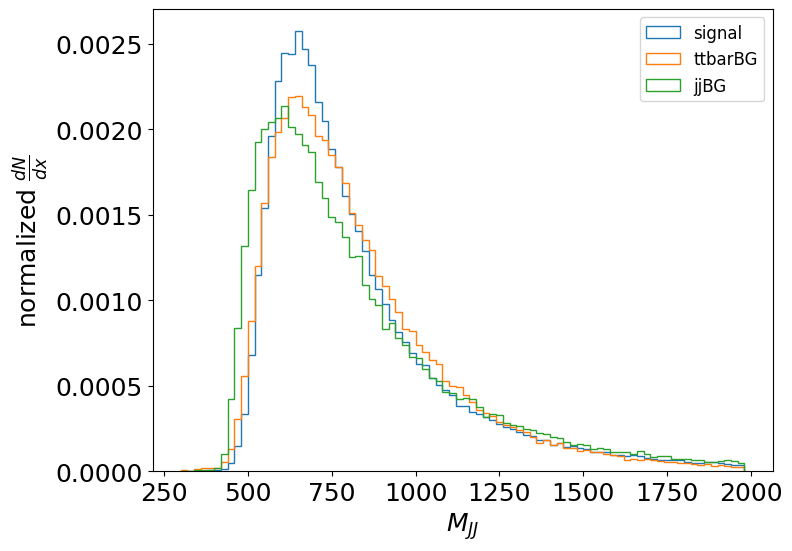

In [8]:
##### plot M_JJ distribution #####

sig_m_JJ = []
ttbarBG_m_JJ = []
jjBG_m_JJ = []

for i in range(len(sig_events)):
    sig_m_JJ.append(m_JJ(sig_events[i]))
    
for i in range(len(ttbarBG_events)):
    ttbarBG_m_JJ.append(m_JJ(ttbarBG_events[i]))
    
for i in range(len(jjBG_events)):
    jjBG_m_JJ.append(m_JJ(jjBG_events[i]))
    
plt.figure(1, figsize=(8,6))
bins = np.arange(300,2000,20)
plt.hist(sig_m_JJ, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_m_JJ, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_m_JJ, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$M_{JJ}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

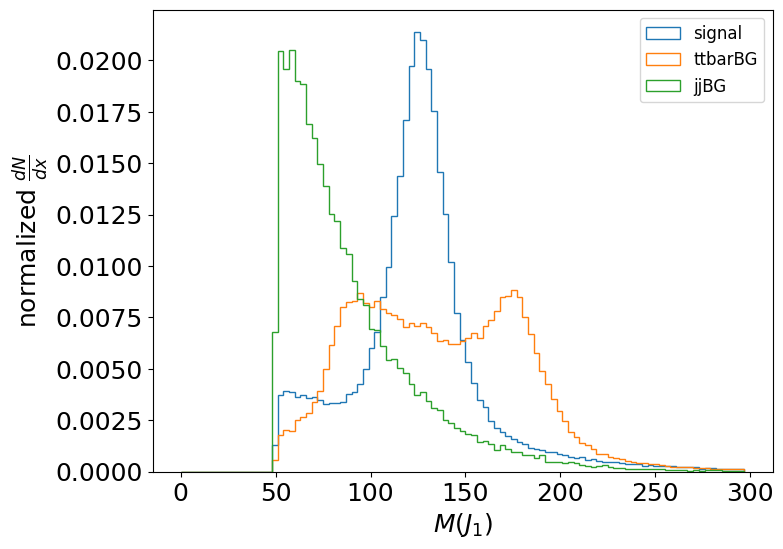

In [9]:
##### plot M_J1 distribution #####

sig_m_J1 = []
ttbarBG_m_J1 = []
jjBG_m_J1 = []

for i in range(len(sig_events)):
    sig_m_J1.append(sig_events[i][4][0])
    
for i in range(len(ttbarBG_events)):
    ttbarBG_m_J1.append(ttbarBG_events[i][4][0])
    
for i in range(len(jjBG_events)):
    jjBG_m_J1.append(jjBG_events[i][4][0])
    
plt.figure(1, figsize=(8,6))
bins = np.arange(0,300,3)
plt.hist(sig_m_J1, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_m_J1, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_m_J1, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$M(J_1)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

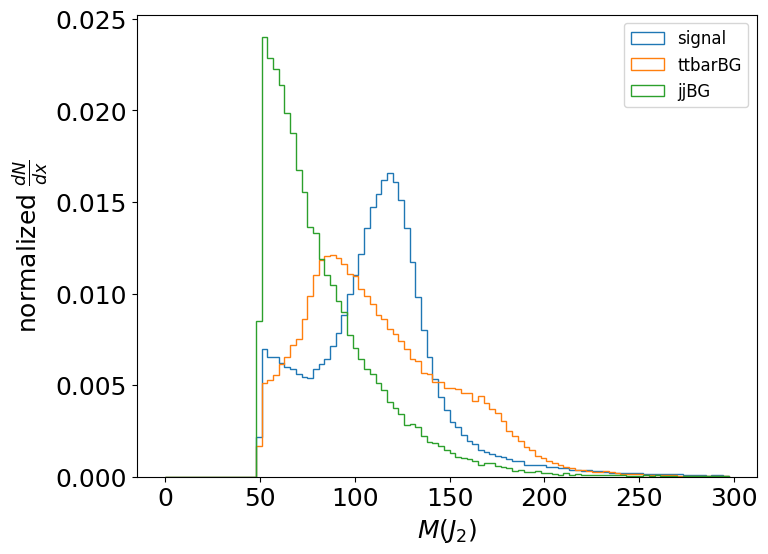

In [10]:
##### plot M_J2 distribution #####

sig_m_J2 = []
ttbarBG_m_J2 = []
jjBG_m_J2 = []

for i in range(len(sig_events)):
    sig_m_J2.append(sig_events[i][4][1])
    
for i in range(len(ttbarBG_events)):
    ttbarBG_m_J2.append(ttbarBG_events[i][4][1])
    
for i in range(len(jjBG_events)):
    jjBG_m_J2.append(jjBG_events[i][4][1])
    
plt.figure(1, figsize=(8,6))
bins = np.arange(0,300,3)
plt.hist(sig_m_J2, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_m_J2, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_m_J2, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$M(J_2)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

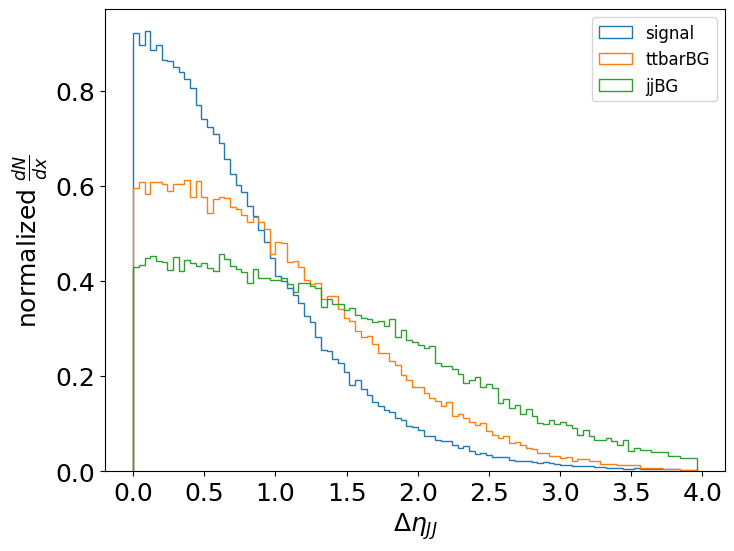

In [11]:
##### plot deta_JJ distribution #####

sig_deta_JJ = []
ttbarBG_deta_JJ = []
jjBG_deta_JJ = []

for i in range(len(sig_events)):
    sig_deta_JJ.append(deta_JJ(sig_events[i]))
    
for i in range(len(ttbarBG_events)):
    ttbarBG_deta_JJ.append(deta_JJ(ttbarBG_events[i]))
    
for i in range(len(jjBG_events)):
    jjBG_deta_JJ.append(deta_JJ(jjBG_events[i]))
    
plt.figure(1, figsize=(8,6))
bins = np.arange(0,4,0.04)
plt.hist(sig_deta_JJ, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_deta_JJ, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_deta_JJ, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\Delta\eta_{JJ}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

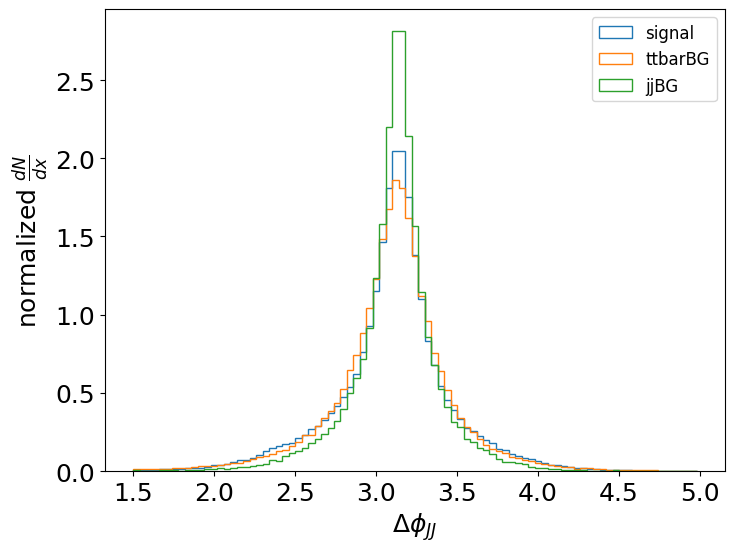

In [12]:
##### plot dphi_JJ distribution #####

sig_dphi_JJ = []
ttbarBG_dphi_JJ = []
jjBG_dphi_JJ = []

for i in range(len(sig_events)):
    sig_dphi_JJ.append(dphi_JJ(sig_events[i]))
    
for i in range(len(ttbarBG_events)):
    ttbarBG_dphi_JJ.append(dphi_JJ(ttbarBG_events[i]))
    
for i in range(len(jjBG_events)):
    jjBG_dphi_JJ.append(dphi_JJ(jjBG_events[i]))
    
plt.figure(1, figsize=(8,6))
bins = np.arange(1.5,5,0.04)
plt.hist(sig_dphi_JJ, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_dphi_JJ, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_dphi_JJ, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\Delta\phi_{JJ}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

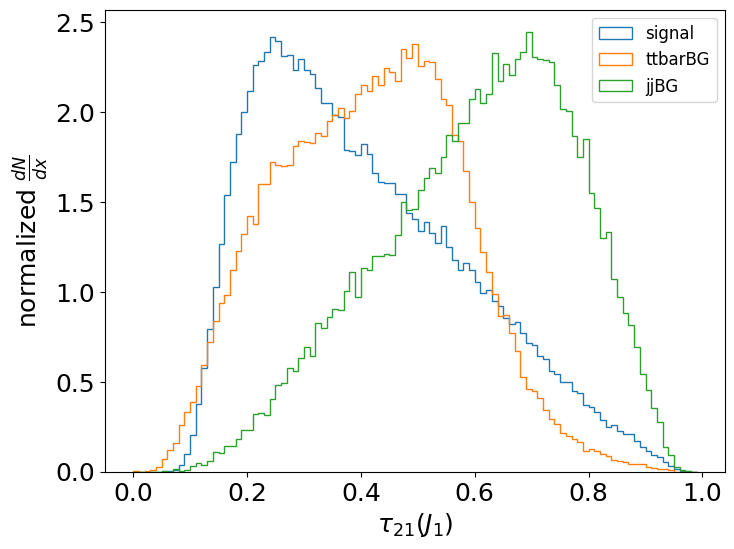

In [13]:
##### plot J1_tau21 distribution #####

sig_J1_tau21 = []
ttbarBG_J1_tau21 = []
jjBG_J1_tau21 = []

for i in range(len(sig_events)):
    sig_J1_tau21.append(J1_tau21(sig_events[i]))
    
for i in range(len(ttbarBG_events)):
    ttbarBG_J1_tau21.append(J1_tau21(ttbarBG_events[i]))
    
for i in range(len(jjBG_events)):
    jjBG_J1_tau21.append(J1_tau21(jjBG_events[i]))
    
plt.figure(1, figsize=(8,6))
bins = np.arange(0,1,0.01)
plt.hist(sig_J1_tau21, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_J1_tau21, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_J1_tau21, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\tau_{21}(J_1)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

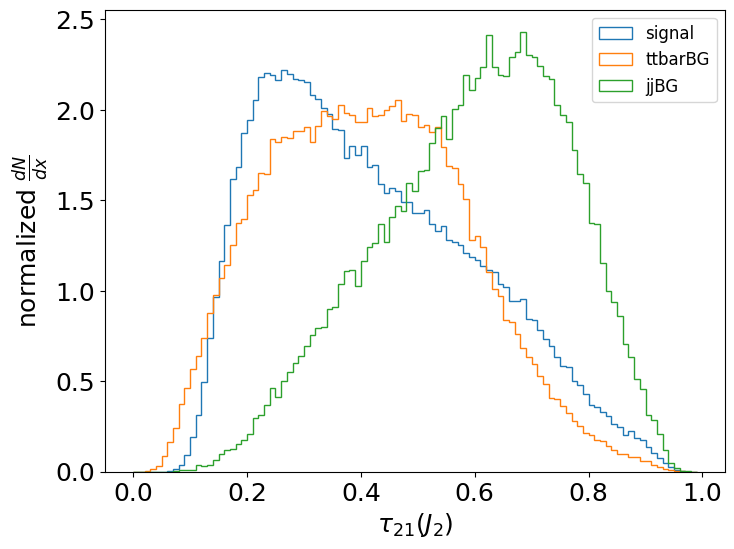

In [14]:
##### plot J2_tau21 distribution #####

sig_J2_tau21 = []
ttbarBG_J2_tau21 = []
jjBG_J2_tau21 = []

for i in range(len(sig_events)):
    sig_J2_tau21.append(J2_tau21(sig_events[i]))
    
for i in range(len(ttbarBG_events)):
    ttbarBG_J2_tau21.append(J2_tau21(ttbarBG_events[i]))
    
for i in range(len(jjBG_events)):
    jjBG_J2_tau21.append(J2_tau21(jjBG_events[i]))
    
plt.figure(1, figsize=(8,6))
bins = np.arange(0,1,0.01)
plt.hist(sig_J2_tau21, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_J2_tau21, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_J2_tau21, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\tau_{21}(J_2)$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

time: 1647.7667820453644


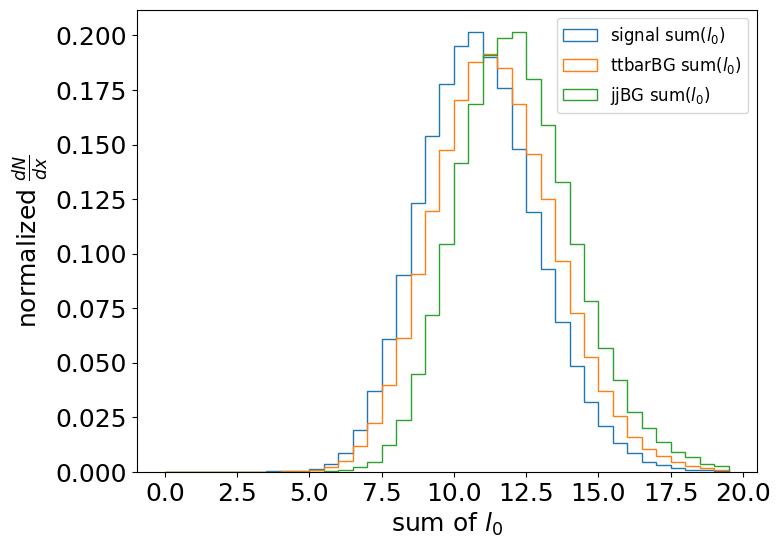

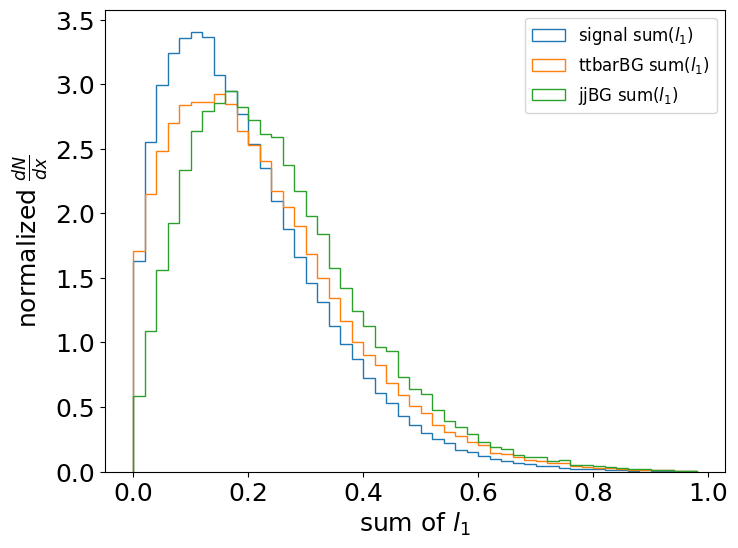

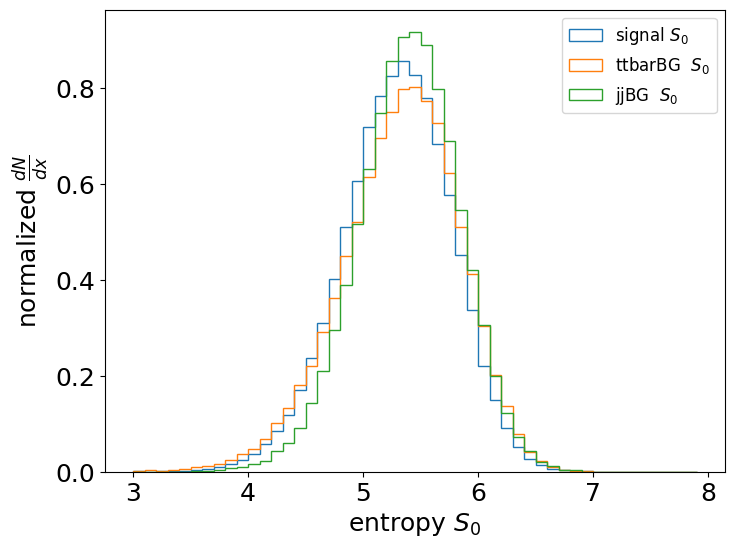

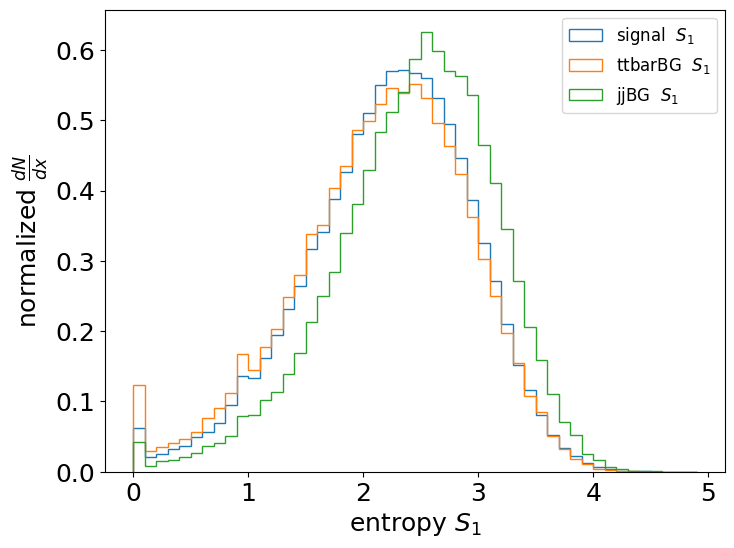

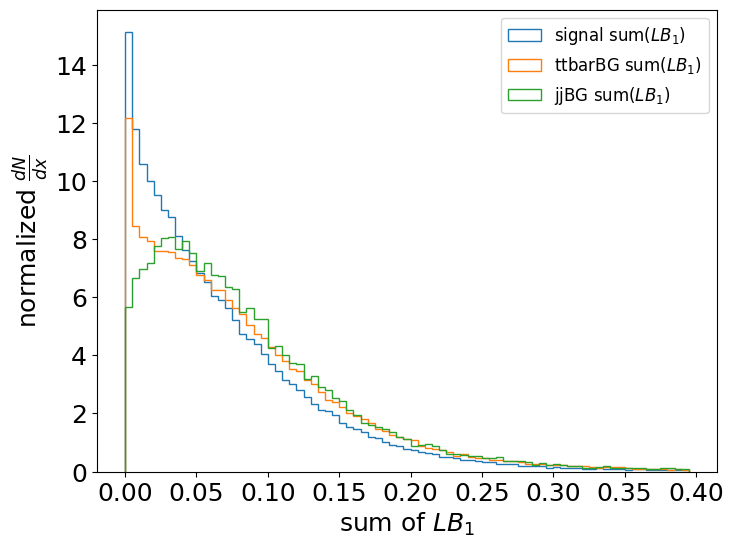

In [15]:
##### plot sum of the TDA variable #####

H_0_sig = []
H_1_sig = []
SS_0_sig = []
SS_1_sig = []
LB_1_sig = []
for i in range(len(sig_events)):
    TDA_tmp = TDA(sig_events[i])
    H_0_sig.append(TDA_sum(TDA_tmp)[0])        ### H is the sum of lifetime
    H_1_sig.append(TDA_sum(TDA_tmp)[1])
    SS_0_sig.append(TDA_entropy(TDA_tmp)[0])   ### SS is the entropy of lifetime
    SS_1_sig.append(TDA_entropy(TDA_tmp)[1])
    LB_1_sig.append(TDA_LB(TDA_tmp))           ### LB is the lifetime*birthtime
    
H_0_ttbarBG = []
H_1_ttbarBG = []
SS_0_ttbarBG = []
SS_1_ttbarBG = []
LB_1_ttbarBG = []
for i in range(len(ttbarBG_events)):
    TDA_tmp = TDA(ttbarBG_events[i])
    H_0_ttbarBG.append(TDA_sum(TDA_tmp)[0])
    H_1_ttbarBG.append(TDA_sum(TDA_tmp)[1])
    SS_0_ttbarBG.append(TDA_entropy(TDA_tmp)[0])
    SS_1_ttbarBG.append(TDA_entropy(TDA_tmp)[1])
    LB_1_ttbarBG.append(TDA_LB(TDA_tmp))
    
H_0_jjBG = []
H_1_jjBG = []
SS_0_jjBG = []
SS_1_jjBG = []
LB_1_jjBG = []
for i in range(len(jjBG_events)):
    TDA_tmp = TDA(jjBG_events[i])
    H_0_jjBG.append(TDA_sum(TDA_tmp)[0])
    H_1_jjBG.append(TDA_sum(TDA_tmp)[1])
    SS_0_jjBG.append(TDA_entropy(TDA_tmp)[0])
    SS_1_jjBG.append(TDA_entropy(TDA_tmp)[1])
    LB_1_jjBG.append(TDA_LB(TDA_tmp))  
    
print("time:", time.time()-t1)
    
##### plot TDA sum of lifetime #####

plt.figure(1, figsize=(8,6))
bins = np.arange(0,20,0.5)
plt.hist(H_0_sig, bins=bins, label=r"signal sum($l_0$)", histtype='step', density=True)     ### l labels lifetime
plt.hist(H_0_ttbarBG, bins=bins, label=r"ttbarBG sum($l_0$)", histtype='step', density=True)
plt.hist(H_0_jjBG, bins=bins, label=r"jjBG sum($l_0$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $l_0$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

plt.figure(1, figsize=(8,6))
bins = np.arange(0,1,0.02)
plt.hist(H_1_sig, bins=bins, label=r"signal sum($l_1$)", histtype='step', density=True)
plt.hist(H_1_ttbarBG, bins=bins, label=r"ttbarBG sum($l_1$)", histtype='step', density=True)
plt.hist(H_1_jjBG, bins=bins, label=r"jjBG sum($l_1$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $l_1$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

##### plot TDA entropy #####

plt.figure(1, figsize=(8,6))
bins = np.arange(3,8,0.1)
plt.hist(SS_0_sig, bins=bins, label=r"signal $S_0$", histtype='step', density=True)
plt.hist(SS_0_ttbarBG, bins=bins, label=r"ttbarBG  $S_0$", histtype='step', density=True)
plt.hist(SS_0_jjBG, bins=bins, label=r"jjBG  $S_0$", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"entropy $S_0$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

plt.figure(1, figsize=(8,6))
bins = np.arange(0,5,0.1)
plt.hist(SS_1_sig, bins=bins, label=r"signal  $S_1$", histtype='step', density=True)
plt.hist(SS_1_ttbarBG, bins=bins, label=r"ttbarBG  $S_1$", histtype='step', density=True)
plt.hist(SS_1_jjBG, bins=bins, label=r"jjBG  $S_1$", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"entropy $S_1$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

##### plot TDA lifetime*birthtime #####

plt.figure(1, figsize=(8,6))
bins = np.arange(0,0.4,0.005)
plt.hist(LB_1_sig, bins=bins, label=r"signal sum($LB_1$)", histtype='step', density=True)
plt.hist(LB_1_ttbarBG, bins=bins, label=r"ttbarBG sum($LB_1$)", histtype='step', density=True)
plt.hist(LB_1_jjBG, bins=bins, label=r"jjBG sum($LB_1$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $LB_1$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

In [16]:
d = {'X_HH':sig_X_HH, 'iht':sig_iht, 'm_JJ':sig_m_JJ, 'm_J1':sig_m_J1, 'm_J2':sig_m_J2, 'deta_JJ':sig_deta_JJ, 'J1_tau21':sig_J1_tau21, 'J2_tau21':sig_J2_tau21, 'H_0':H_0_sig, 'H_1':H_1_sig, 'SS_0':SS_0_sig, 'SS_1':SS_1_sig, 'LB_1':LB_1_sig}
df = pd.DataFrame(data=d)
df

,X_HH,iht,m_JJ,m_J1,m_J2,deta_JJ,J1_tau21,J2_tau21,H_0,H_1,SS_0,SS_1,LB_1
0,2.169814,498.863251,552.356994,102.008881,112.236855,0.482302,0.221553,0.385671,13.233662,0.314678,5.709411,1.573460,0.355070
1,9.475008,593.795044,597.207660,67.299019,80.223694,0.341132,0.742909,0.179675,10.209827,0.090669,4.825404,2.549878,0.018734
2,11.972177,505.011780,638.938097,56.588074,102.755157,1.329138,0.750892,0.413120,11.556087,0.207381,5.250363,2.171730,0.081837
3,3.305570,639.797974,709.878242,136.601318,168.479492,0.386040,0.395503,0.343482,14.189290,0.422620,6.027356,2.983404,0.161782
4,6.146391,496.671631,524.943021,88.915337,80.513718,0.158647,0.406887,0.329383,8.284440,0.056204,5.248461,2.160549,0.004379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140266,0.729532,540.726196,615.060237,122.242760,118.937485,0.598478,0.120600,0.224170,7.341038,0.105586,4.223098,1.155893,0.054234
140267,14.288343,574.796021,624.642916,53.831547,72.544083,0.722689,0.695849,0.459742,11.767448,0.232464,5.060846,2.297582,0.115098
140268,0.885607,650.270508,679.858607,116.234673,113.978821,0.280516,0.153519,0.267932,10.253675,0.073889,5.406869,2.377840,0.020672
140269,3.399489,563.574829,616.067002,92.819305,121.324234,0.396658,0.683782,0.223638,13.101508,0.228117,5.580477,2.384999,0.110524


In [17]:
corr_map = df.corr()
corr_map.round(3)

,X_HH,iht,m_JJ,m_J1,m_J2,deta_JJ,J1_tau21,J2_tau21,H_0,H_1,SS_0,SS_1,LB_1
X_HH,1.000,-0.029,0.002,-0.160,-0.347,0.081,0.318,0.439,-0.028,-0.046,-0.168,-0.115,0.005
iht,-0.029,1.000,0.853,0.429,0.474,0.056,0.124,0.063,-0.070,-0.024,-0.012,0.135,-0.071
m_JJ,0.002,0.853,1.000,0.379,0.404,0.478,0.114,0.083,0.048,0.006,-0.034,0.135,-0.032
m_J1,-0.160,0.429,0.379,1.000,0.180,-0.004,-0.243,0.017,0.203,0.175,0.305,0.218,0.080
m_J2,-0.347,0.474,0.404,0.180,1.000,-0.031,0.040,-0.295,0.175,0.157,0.283,0.201,0.067
deta_JJ,0.081,0.056,0.478,-0.004,-0.031,1.000,0.045,0.086,0.165,0.029,-0.080,0.032,0.026
J1_tau21,0.318,0.124,0.114,-0.243,0.040,0.045,1.000,0.017,0.216,0.171,0.194,0.154,0.108
J2_tau21,0.439,0.063,0.083,0.017,-0.295,0.086,0.017,1.000,0.237,0.190,0.195,0.148,0.132
H_0,-0.028,-0.070,0.048,0.203,0.175,0.165,0.216,0.237,1.000,0.675,0.728,0.447,0.527
H_1,-0.046,-0.024,0.006,0.175,0.157,0.029,0.171,0.190,0.675,1.000,0.633,0.437,0.802


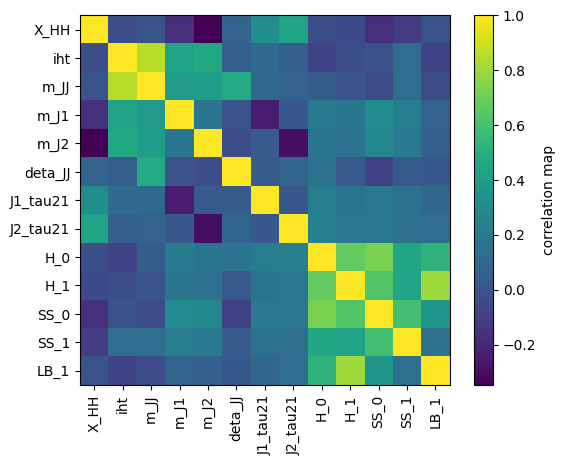

In [18]:
fig, ax = plt.subplots(1,1)
pcm = ax.imshow(corr_map, )
plt.colorbar(pcm, label='correlation map')
ax.set_xticks(np.arange(13))
ax.set_yticks(np.arange(13))
ax.set_xticklabels(df.columns, rotation=90)
ax.set_yticklabels(df.columns)
plt.show()     

In [19]:
sig_events[0]

array([2, array([1.792529 , 2.2748308], dtype=float32),
       array([ 3.0276995 , -0.13593715], dtype=float32),
       array([282.09735, 216.7659 ], dtype=float32),
       array([102.00888 , 112.236855], dtype=float32),
       array([[0.27272147, 0.06042235, 0.055989  , 0.04688989, 0.0385822 ],
              [0.37780148, 0.1457072 , 0.0804381 , 0.06765796, 0.05972432]],
             dtype=float32)                                                 ,
       list([[1917, 1660, 1885, 990, 1474, 1758, 1756, 1564, 966, 1757, 1362, 1361, 1756, 2077, 1755, 1028, 1356, 1571, 1355, 2078, 1360, 970, 1570, 1363, 1759, 1893, 1573, 1891, 2039, 2038, 1574, 1568, 1884, 1555, 954, 2095, 2030, 2032, 2094, 1554, 1556, 2033, 2035, 1559, 2074, 1559, 2030, 2031, 2032, 2074, 2075, 2034], [1241, 1178, 2098, 1853, 2099, 2070, 2017, 2069, 2016, 1847, 2100, 1844, 2088, 2101, 1846, 2012, 924, 2087, 1329, 1184, 1397, 1106, 1679, 1743, 928, 1753, 1181, 1866, 936, 1185, 1399, 1873, 1551, 1871, 2072, 2028, 2025, 2073,